In [1]:
!pip install matplotlib scikit-image

import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from skimage.io import imread
from skimage.color import rgb2gray
from skimage import exposure
from skimage import color
from skimage.feature import hog
from skimage.filters import threshold_otsu
from skimage.filters import threshold_local
from skimage.morphology import binary_erosion
from skimage.measure import regionprops, find_contours

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from sklearn.cluster import KMeans
from skimage import filters
from skimage.filters import threshold_otsu, sobel, gaussian, threshold_local


2023-07-28 09:31:38.538631: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-28 09:31:38.562162: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the image paths and labels from the DataFrame
df = pd.read_csv('Dataset/cards.csv')

# For column names that contain space, replace the space with an underscore
df.columns = [c.replace(' ', '_') for c in df.columns]

# Add suits column
df['suit'] = df['labels'].str.split().str[-1]

# Remove rows with jokers
df = df[~df['suit'].str.contains('joker', case=False)]

# Remove unwanted columns
df = df.drop(columns = ['data_set'])
df = df.drop(columns = ['class_index'])
df = df.drop(columns = ['labels'])
df = df.drop(columns = ['card_type'])

# Add folder name to the filepath
df['filepaths'] = df['filepaths'].apply(lambda x: 'DatasetPreProcessed/' + x)
df.head()

,filepaths,suit
0,DatasetPreProcessed/train/ace of clubs/001.jpg,clubs
1,DatasetPreProcessed/train/ace of clubs/002.jpg,clubs
2,DatasetPreProcessed/train/ace of clubs/003.jpg,clubs
3,DatasetPreProcessed/train/ace of clubs/004.jpg,clubs
4,DatasetPreProcessed/train/ace of clubs/005.jpg,clubs


In [3]:
# Split dataframe into train and test sets, stratified by the 'suit' column
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['suit'], random_state=42)

# Split train set into train and validation sets, stratified by the 'suit' column
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['suit'], random_state=42)

# Check class distribution in the train, validation, and test sets
train_class_distribution = train_df['suit'].value_counts(normalize=True)
val_class_distribution = val_df['suit'].value_counts(normalize=True)
test_class_distribution = test_df['suit'].value_counts(normalize=True)

print("Train Set - Class Distribution:")
print(train_class_distribution)

print("Validation Set - Class Distribution:")
print(val_class_distribution)

print("Test Set - Class Distribution:")
print(test_class_distribution)

Train Set - Class Distribution:
spades      0.269171
hearts      0.246010
diamonds    0.243675
clubs       0.241144
Name: suit, dtype: float64
Validation Set - Class Distribution:
spades      0.269261
hearts      0.245914
diamonds    0.243580
clubs       0.241245
Name: suit, dtype: float64
Test Set - Class Distribution:
spades      0.268991
hearts      0.245953
diamonds    0.244085
clubs       0.240971
Name: suit, dtype: float64


## Augment Images

In [4]:
# Initialize data generator class

train_data_generator = ImageDataGenerator(
    rescale = 1/255.0,
    rotation_range= 45,
    zoom_range= 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range= 0.2,
    horizontal_flip=True,
    vertical_flip=True
)

test_data_generator = ImageDataGenerator(rescale = 1/255.0)

# Create data generators for train, validation, and test
batch_size = 32

train_generator = train_data_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical'
)

valid_generator = train_data_generator.flow_from_dataframe(
    dataframe = val_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical'
)


test_generator = test_data_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False,
)


Found 5138 validated image filenames belonging to 4 classes.
Found 1285 validated image filenames belonging to 4 classes.
Found 1606 validated image filenames belonging to 4 classes.


In [5]:
# def preprocess_image(image):
#     # Convert the image to grayscale.
#     image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# #     if len(image.shape) == 3 and image.shape[-1] == 3:
# #         image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# #     else:
# #         image_gray = image
#     return image_gray

def preprocess_image(image):
    # Convert the image to grayscale.
#     if len(image.shape) == 3 and image.shape[-1] == 3:
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#     else:
#         image_gray = image

#     # Ensure the image is of type uint8 (8-bit).
#     if image_gray.dtype != np.uint8:
#         image_gray = image_gray.astype(np.uint8)

    return image_gray


#logarithmic correction - replaces pixels with their log value
def log_correction(image):
    log_adjusted_image =  exposure.adjust_log(image)
    return log_adjusted_image

#gamma correction - adjusts brightness of image
def gamma_correction(image):
    random_gamma = np.random.uniform(low = 0, high = 1)
    
    gamma_adjusted_image = exposure.adjust_gamma(log_correction(image), 2)
    return gamma_adjusted_image

# BLURRING AND SHARPENING
# Blurring the image
def blur_image(image):
    blur_img = gaussian(gamma_correction(image), sigma = 3)
    return blur_img

# Sharpening image
def sharpen_image(image):
    blurred_image = blur_image(image)
    sharp_img = image + (image - blurred_image)
    return sharp_img

# NORMALIZATION
def normalize_img(image):
    normalized = (sharpen_image(image) - np.min(sharpen_image(image)))/(np.max(sharpen_image(image)) - np.min(sharpen_image(image)))   
    return normalized

def extract_hog_features(image_path):
    image = load_img(image_path)
    image_array = img_to_array(image)
    image_gray = preprocess_image(image_array)
    preprocessed = normalize_img(image_gray)
    
    # Apply Gaussian smoothing to the grayscale image.
#     smoothed_image = filters.gaussian(image_gray, sigma=1.0)

    # Calculate HOG features for the suit region.
    fd, hog_image = hog(preprocessed,
                        orientations=8,
                        pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2),
                        visualize=True)

    # Normalize the HOG features.
    hog_features = exposure.rescale_intensity(fd, in_range=(0, 10))
    
    return hog_features

In [6]:
# Extract the HOG features from the DataFrame and create a list of feature arrays.
hog_features_list_train = []
y_train_collected = []

for i in range(len(train_generator.filenames)):
    image_path = train_generator.filepaths[i]
    hog_features = extract_hog_features(image_path)
#     if hog_features is not None:
#         if len(hog_features) == 768: 
    hog_features_list_train.append(hog_features)
    y_train_collected.append(train_generator.labels[i])

# Convert the list of HOG feature arrays into a 2D array
hog_features_array_train = np.vstack(hog_features_list_train)
y_train_collected = np.array(y_train_collected)

In [7]:
# Extract HOG features for validation data
hog_features_list_valid = []
y_valid_collected = []

for i in range(len(valid_generator.filenames)):
    image_path = valid_generator.filepaths[i]
    hog_features = extract_hog_features(image_path)
#     if hog_features is not None and len(hog_features) == 768:
    hog_features_list_valid.append(hog_features)
    y_valid_collected.append(valid_generator.labels[i])

# Convert the list of HOG feature arrays into a 2D array
hog_features_array_valid = np.vstack(hog_features_list_valid)
y_valid_collected = np.array(y_valid_collected)

In [8]:
# Extract HOG features for test data
hog_features_list_test = []
y_test_collected = []

for i in range(len(test_generator.filenames)):
    image_path = test_generator.filepaths[i]
    hog_features = extract_hog_features(image_path)
#     if hog_features is not None and len(hog_features) == 768:
    hog_features_list_test.append(hog_features)
    y_test_collected.append(test_generator.labels[i])

# Convert the list of HOG feature arrays into a 2D array
hog_features_array_test = np.vstack(hog_features_list_test)
y_test_collected = np.array(y_test_collected)

In [21]:
def create_cnn_model(input_shape, num_classes, learning_rate=0.0001):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.03))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.03))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [22]:
# Define the input shape for the CNN model based on the number of HOG features (768).
input_shape = (hog_features_array_train.shape[1],)

# Define the number of classes for the output layer.
num_classes = 4

# Create the CNN model
model = create_cnn_model(input_shape, num_classes)

In [23]:
# Convert the labels to one-hot encoded format
y_train_onehot = to_categorical(y_train_collected, num_classes=4)
y_valid_onehot = to_categorical(y_valid_collected, num_classes=4)

# Train the CNN model
history = model.fit(hog_features_array_train, y_train_onehot,
                        batch_size=32,
                        epochs=15, 
                        validation_data=(hog_features_array_valid, y_valid_onehot))


Epoch 1/15
161/161 [==============================] - 1s 5ms/step - loss: 1.3419 - accuracy: 0.3953 - val_loss: 1.2710 - val_accuracy: 0.5502
Epoch 2/15
161/161 [==============================] - 1s 4ms/step - loss: 1.1613 - accuracy: 0.6024 - val_loss: 1.0759 - val_accuracy: 0.6553
Epoch 3/15
161/161 [==============================] - 1s 4ms/step - loss: 0.9558 - accuracy: 0.6987 - val_loss: 0.9156 - val_accuracy: 0.6957
Epoch 4/15
161/161 [==============================] - 1s 4ms/step - loss: 0.7807 - accuracy: 0.7604 - val_loss: 0.8066 - val_accuracy: 0.7268
Epoch 5/15
161/161 [==============================] - 1s 4ms/step - loss: 0.6685 - accuracy: 0.7978 - val_loss: 0.7383 - val_accuracy: 0.7447
Epoch 6/15
161/161 [==============================] - 1s 4ms/step - loss: 0.5883 - accuracy: 0.8229 - val_loss: 0.7328 - val_accuracy: 0.7089
Epoch 7/15
161/161 [==============================] - 1s 5ms/step - loss: 0.5119 - accuracy: 0.8575 - val_loss: 0.6592 - val_accuracy: 0.7619
Epoch 

In [24]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(hog_features_array_test, to_categorical(y_test_collected, num_classes))
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


51/51 [==============================] - 0s 4ms/step - loss: 0.6035 - accuracy: 0.7895
Test Loss: 0.6035, Test Accuracy: 0.7895


In [25]:
# Make predictions on the test data
predictions_probabilities = model.predict(hog_features_array_test)
predicted_labels = np.argmax(predictions_probabilities, axis=1)
print(predicted_labels)

51/51 [==============================] - 0s 1ms/step
[0 2 3 ... 3 3 1]


In [26]:
# Get the class names from the generator
class_names = list(test_generator.class_indices.keys())

# Generate the classification report
report = classification_report(y_test_collected, predicted_labels, target_names=class_names)

# Print the classification report
print(report)


              precision    recall  f1-score   support

       clubs       0.78      0.78      0.78       387
    diamonds       0.87      0.76      0.81       392
      hearts       0.78      0.83      0.80       395
      spades       0.75      0.80      0.77       432

    accuracy                           0.79      1606
   macro avg       0.79      0.79      0.79      1606
weighted avg       0.79      0.79      0.79      1606



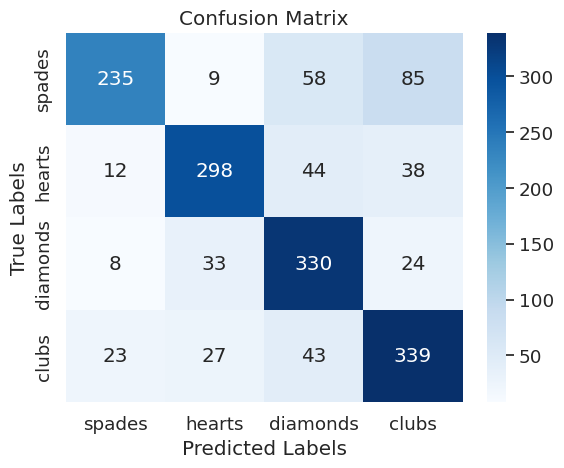

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test_collected, predicted_labels)

# Define the class labels
class_labels = ['spades', 'hearts', 'diamonds', 'clubs']

# Create the seaborn heatmap
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import load_diabetes

X,y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Creating a Model
model = GradientBoostingRegressor()

# Define the hyperparameter grid
param_grid = {'learning_rate': [0.2,0.02,0.02,1],
              'max_depth'    : [2,4,6,8,10]
                 }

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs = -1)


# Perform the grid search
grid_search.fit(X_train, y_train)

# Access the best hyperparameters and best score
best_learning_rate = grid_search.best_params_['learning_rate']
best_max_depth = grid_search.best_params_['max_depth']
best_score = grid_search.best_score_

# Print the results
print("Best learning rate:", best_learning_rate)
print("Best Depth:", best_max_depth)
print("Best score (MSE):", best_score)

In [ ]:
!pip install scikeras
from sklearn.model_selection import GridSearchCV, KFold
from keras.wrappers.scikit_learn import KerasClassifier

# Wrap the Keras model with the KerasClassifier for scikit-learn compatibility
model_wrapper = KerasClassifier(build_fn=create_cnn_model, input_shape=input_shape, num_classes=4)

# Define the hyperparameters to search over
param_grid = {
    'batch_size': [16, 32],
    'epochs': [10, 20, 30],
    'learning_rate': [0.0001, 0.001, 0.01]
}

custom_cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=model_wrapper, param_grid=param_grid, cv=custom_cv, n_jobs=-1)

# Perform hyperparameter search using subsets of the validation data
grid_result = grid_search.fit(hog_features_array_valid, y_valid_onehot)

# Get the best hyperparameters and evaluate the model with them on the test set
best_params = grid_result.best_params_
best_model = grid_result.best_estimator_.model
# best_model.summary()

# # Train the best model on the full training data
# best_model.fit(hog_features_array_train, y_train_onehot, batch_size=best_params['batch_size'], epochs=best_params['epochs'])

# # Evaluate the best model on the test set
# test_loss, test_accuracy = best_model.evaluate(hog_features_array_test, y_test_collected)
# print("Test Accuracy:", test_accuracy)


# Evaluate the model on the test data
test_loss, test_accuracy = best_model.evaluate(hog_features_array_test, to_categorical(y_test_collected, num_classes))
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Make predictions on the test data
predictions_probabilities = best_model.predict(hog_features_array_test)
predicted_labels = np.argmax(predictions_probabilities, axis=1)
print(predicted_labels)

# Get the class names from the generator
class_names = list(test_generator.class_indices.keys())

# Generate the classification report
report = classification_report(y_test_collected, predicted_labels, target_names=class_names)

# Print the classification report
print(report)


In [ ]:
# Load and preprocess the images
def load_and_preprocess_image(filepath):
    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

# Convert to image to grayscale
def convert_to_grayscale(images):
    gray_images = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images])
    gray_images = gray_images.astype(np.uint8)
    return gray_images

# Extract HOG feature vectors
def extract_hog_features(images):
    hog_features_list = []
    for img in images:
        hog_feature = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=4, visualize=True)
        hog_features_list.append(hog_feature)
    hog_features = np.vstack(hog_features_list)
    
    return hog_features

In [ ]:
# Load data from the generators and extract HOG features
train_images = np.array([load_and_preprocess_image(train_generator.filepaths[i]) for i in range(len(train_generator.filenames))])
valid_images = np.array([load_and_preprocess_image(valid_generator.filepaths[j]) for j in range(len(valid_generator.filenames))])
test_images = np.array([load_and_preprocess_image(test_generator.filepaths[k]) for k in range(len(test_generator.filenames))])

# Convert to grayscale
train_gray_images = convert_to_grayscale(train_images)
valid_gray_images = convert_to_grayscale(valid_images)
test_gray_images = convert_to_grayscale(test_images)

# Extract HOG feature vectors
train_hog_features = extract_hog_features(train_gray_images)
valid_hog_features = extract_hog_features(valid_gray_images)
test_hog_features = extract_hog_features(test_gray_images)

# Convert labels to arrays and one-hot encode 
train_labels = to_categorical(train_generator.labels, num_classes=4)
valid_labels = to_categorical(valid_generator.labels, num_classes=4)
test_labels = to_categorical(test_generator.labels, num_classes=4)


In [ ]:
# SVM using the train HOG features
num_classes = 4

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(train_hog_features.shape[1],)))
model.add(Dropout(0.03))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.03))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the CNN model
history = model.fit(train_hog_features, train_labels,
                    batch_size=32,
                    epochs=20,
                    validation_data=(valid_hog_features, valid_labels))


In [ ]:
# Make predictions on the validation set
valid_predictions_probs = model.predict(valid_hog_features)
valid_predictions = np.argmax(valid_predictions_probs, axis=1)

# Calculate validation accuracy
valid_accuracy = accuracy_score(valid_generator.labels, valid_predictions)
print("Validation Accuracy:", valid_accuracy)

# Make predictions on the test set
test_predictions_probs = model.predict(test_hog_features)
test_predictions = np.argmax(test_predictions_probs, axis=1)

# Calculate test accuracy
test_accuracy = accuracy_score(test_generator.labels, test_predictions)
print("Test Accuracy:", test_accuracy)

In [ ]:
# Get the class names from the generator (assuming it has the 'class_indices' attribute)
class_names = list(test_generator.class_indices.keys())

# Calculate classification report for validation set
valid_report = classification_report(valid_generator.labels, valid_predictions, target_names=class_names)
print("Validation Classification Report:\n", valid_report)

# Calculate classification report for test set
test_report = classification_report(test_generator.labels, test_predictions, target_names=class_names)
print("Test Classification Report:\n", test_report)

## Sample Images

In [ ]:
sample_filepaths = [
    'Dataset/train/three of diamonds/006.jpg',
    'Dataset/train/three of diamonds/002.jpg',
    'Dataset/train/ace of diamonds/064.jpg',
    'Dataset/train/ace of diamonds/063.jpg',
    'Dataset/train/nine of clubs/024.jpg',
    'Dataset/train/nine of clubs/070.jpg',
    'Dataset/train/ace of clubs/066.jpg',
    'Dataset/train/ace of clubs/047.jpg',
    'Dataset/train/queen of hearts/005.jpg',
    'Dataset/train/three of hearts/056.jpg',
    'Dataset/train/two of hearts/033.jpg',
    'Dataset/train/eight of hearts/100.jpg',
    'Dataset/train/king of spades/005.jpg',
    'Dataset/train/jack of spades/014.jpg',
    'Dataset/train/jack of spades/055.jpg',
    'Dataset/train/seven of spades/055.jpg'
]

# Load and preprocess the sample images
sample_images = np.array([load_and_preprocess_image(filepath) for filepath in sample_filepaths])

# Convert the images to grayscale
sample_gray_images = convert_to_grayscale(sample_images)

# Extract HOG features for the sample images
sample_hog_features = extract_hog_features(sample_gray_images)

# Calculate the number of images
num_images = len(sample_images)

for i in range(num_images):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))

    ax[0].imshow(sample_images[i], cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    hog_image = hog(sample_gray_images[i], pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)[1]
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    ax[1].imshow(hog_image_rescaled, cmap='gray')
    ax[1].set_title('HOG Features')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()


## PCA

In [ ]:
# Perform PCA on the HOG features.
pca = PCA()
hog_features_pca = pca.fit_transform(train_hog_features)

# Cumulative explained variance.
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Determine the number of principal components to plot with increments of 100.
num_components = hog_features_pca.shape[1]
components_range = np.arange(1, num_components + 1, 100)

plt.figure(figsize=(12, 6))
plt.plot(components_range, cumulative_explained_variance[components_range - 1], marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance')
plt.xticks(components_range, fontsize=6)
plt.grid(True)
plt.show()